# Earthquake as a triggering factor in a spatial domain

© 2024 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/infinite_slope_earthquake_spatial.ipynb).


This notebook runs the model ``pyNermarkDisp`` developed by [Montoya-Araque et al., (2024)](https://doi.org/10.1016/j.envsoft.2024.105942) based on the classical sliding rigid block method by [Newmark (1965)](https://doi.org/10.1680/geot.1965.15.2.139).

## Required modules and global setup for plots

In [1]:
import subprocess
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    subprocess.run('pip install pynewmarkdisp', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pynewmarkdisp.newmark import direct_newmark, plot_newmark_integration
from pynewmarkdisp.infslope import factor_of_safety, get_ky
from pynewmarkdisp.spatial import load_ascii_raster, map_zones, plot_spatial_field, spatial_newmark, get_idx_at_coords, verify_newmark_at_cell
from ipywidgets import widgets as wgt

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
        "figure.constrained_layout.use": False
    }
)

## Basic example

### Loading earthquake record and spatial data

In [2]:
url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/pynewmarkdisp/"

# Loading earthquake data
earthquake_record = pd.read_csv(f"{url}earthquake_data_simple.csv", sep=";")
earthquake_record = pd.read_csv(f"{url}earthquake_data_simple.csv", sep=";")
g = 1.0  # It means, accel units are given in fractions of gravity
accel = np.array(earthquake_record["Acceleration"])
time = np.array(earthquake_record["Time"])

# Loading spatial data
dem, header = load_ascii_raster(f"{url}spatial_data_dummy_example/dem.asc")
slope, header = load_ascii_raster(f"{url}spatial_data_dummy_example/slope.asc")
zones, header = load_ascii_raster(f"{url}spatial_data_dummy_example/zones.asc")
depth, header = load_ascii_raster(f"{url}spatial_data_dummy_example/zmax.asc")
depth_w, header = load_ascii_raster(f"{url}spatial_data_dummy_example/depthwt.asc")

### Non-spatial inputs

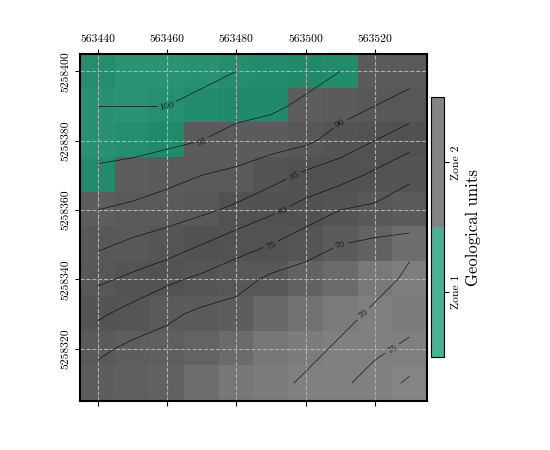

In [3]:
# Geotechnical parameters for each geological zone
parameters = {  # Zone: (𝜙, 𝑐, 𝛾) → Follow this structure. Add as many zones as in the map "zones"
    1: (35, 3.5, 22),
    2: (31, 8, 22),
}

# Geographic reference system
# (Do not modify it if spatial data is loaded from ASCII raster, otherwise,
#  modify the commented lines below)
spat_ref = header
# spat_ref = {
#     'xy_lowerleft': (header["xllcorner"], header["yllcorner"]),
#     'cell_size': header["cellsize"]
# }

# This is for enhancing the visualization of the results (contours)
contours = np.arange(70, 105, 5)  # (min, max, step)

# Associating geotechnical parameters to each geological zone spatially and plotting
phi, c, gamma = map_zones(parameters, zones)
fig = plot_spatial_field(zones, dem, spat_ref=header, levels=contours,
                   title="Geological units", cmap='Dark2', discrete=True,
                   label=['Zone 1', 'Zone 2'], labelrot=90)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'
plt.show()

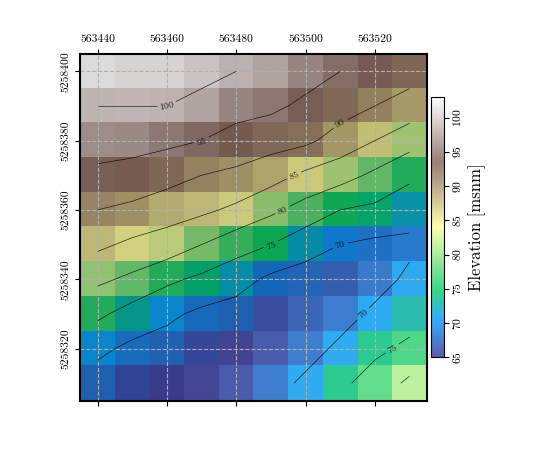

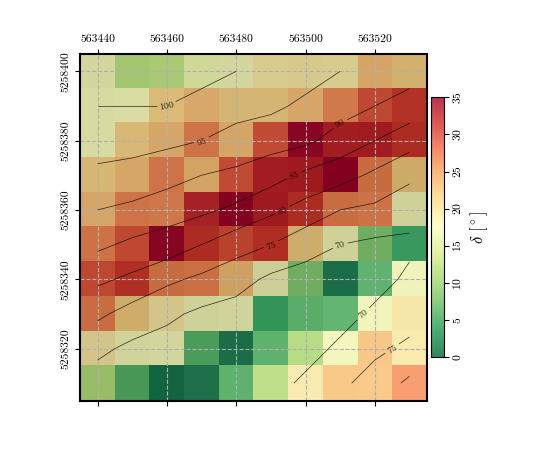

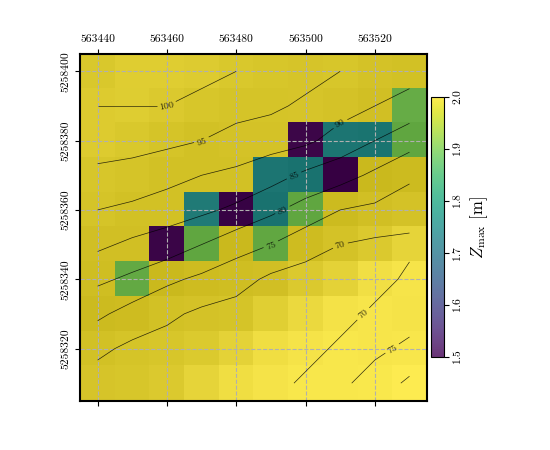

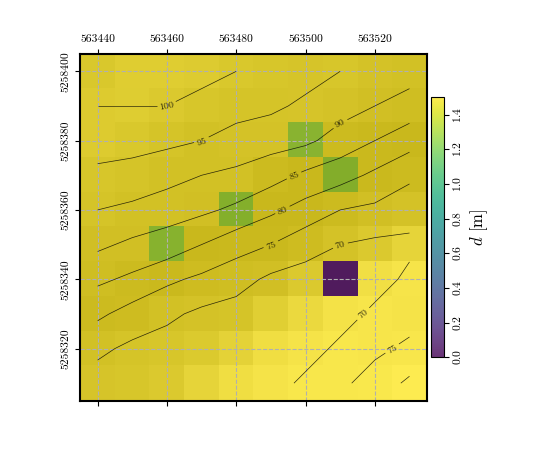

In [4]:
# plotting the digital elevation model (dem)
fig = plot_spatial_field(dem, dem, spat_ref=header, levels=contours, labelrot=90,
                         title="Elevation [msnm]", cmap='terrain', discrete=False)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

# plotting the spatial distribution of slopes
fig = plot_spatial_field(slope, dem, spat_ref=header, levels=contours,
                         title="$\\delta\\ [^\\circ]$", cmap='RdYlGn_r', labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

# plotting the spatial distribution of potential sliding mass depths
fig = plot_spatial_field(depth, dem, spat_ref=header, levels=contours,
                         title="$Z_\\mathrm{max}$ [m]", cmap='viridis', labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

# plotting the spatial distribution of watertable depths
fig = plot_spatial_field(depth_w, dem, spat_ref=header, levels=contours,
                         title="$d$ [m]", cmap='viridis', labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Calculating and plotting the spatial distribution of $\mathrm{FS}_\mathrm{static}$

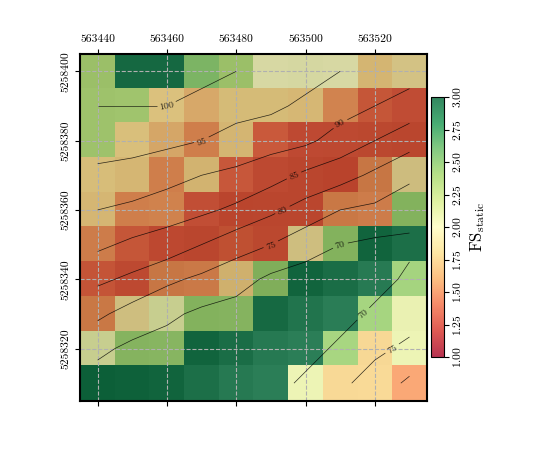

In [5]:
fs = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=0)
fig = plot_spatial_field(fs, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$\\mathrm{FS}_\\mathrm{static}$", vmin=1.0, vmax=3.0, labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Calculating and plotting the spatial distribution of $k_\mathrm{y}$

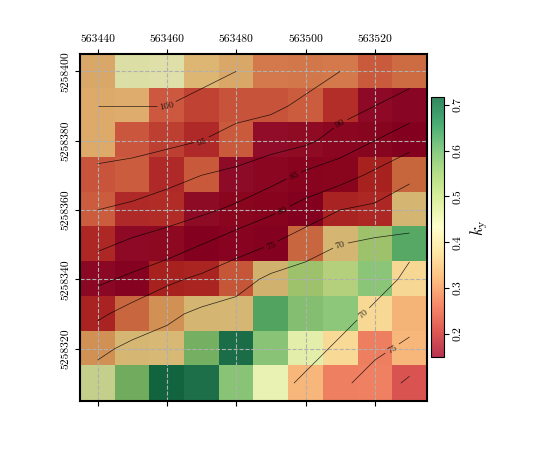

In [6]:
ky = get_ky(depth, depth_w, slope, phi, c, gamma)
fig = plot_spatial_field(ky, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$k_\\mathrm{y}$", labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Calculating and plotting the spatial distribution of $\mathrm{FS}_\mathrm{pseudostatic}$ when $k_\mathrm{s}$ is 40% of $k_\mathrm{y}$

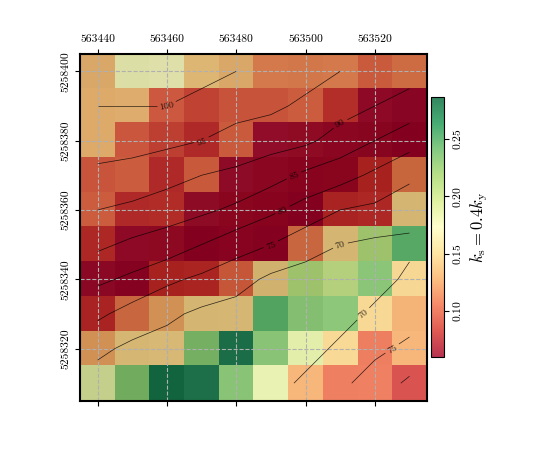

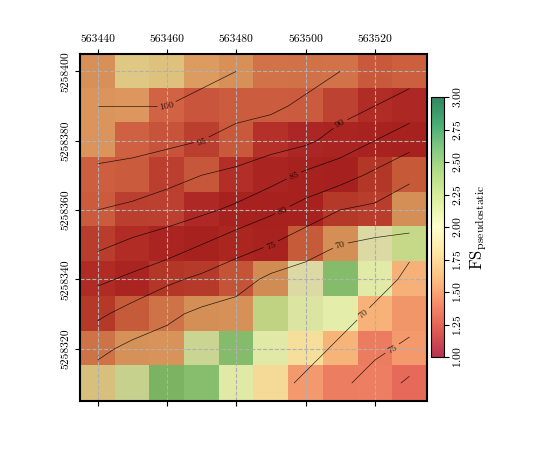

In [7]:
# Calculating factor of safety for pseudostatic conditions and plotting its spatial distribution
ks = 0.4 * ky
fig = plot_spatial_field(ks, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$k_\\mathrm{s} = 0.4 k_\\mathrm{y}$", labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

fs_ks = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=ks)
fig = plot_spatial_field(fs_ks, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$\\mathrm{FS}_\\mathrm{pseudostatic}$", vmin=1.0, vmax=3.0, labelrot=90)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Calculating and plotting the spatial distribution of $u_\mathrm{p}$

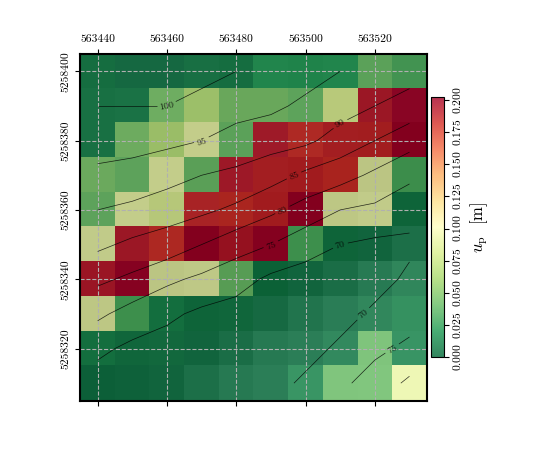

In [8]:
# Calculating permanent displacements and plotting its spatial distribution
permanent_disp = spatial_newmark(time, accel, ky, g)
fig = plot_spatial_field(permanent_disp, dem, spat_ref=header, levels=contours,
                         title="$u_\\mathrm{p}$  [m]", cmap='RdYlGn_r', labelrot=90)
# axis_labels = fig.get_axes()[0].get_xticklabels() + fig.get_axes()[0].get_yticklabels()
# [label.set_fontsize('large') for label in axis_labels]
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Plotting the Newmark method at a specific location

Zone: 2.0, Height: 91.0, Slope: 35.0°, FS: 1.323, kᵧ: 0.159, uₚ: 0.183


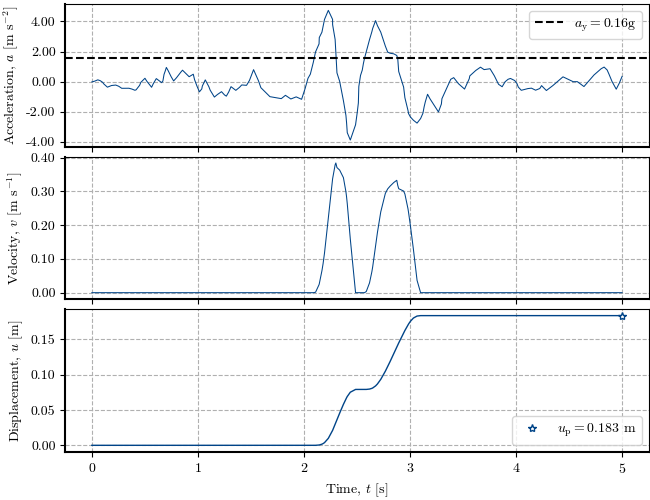

In [9]:
# Verification of the Direct Newmark Method at one cell
x, y = 563500, 5258380 # Coordinates of the cell to verify
cell = get_idx_at_coords(x=x, y=y, spat_ref=header)  # Cell to verify

print(f"Zone: {zones[cell]}, Height: {dem[cell]}, Slope: {slope[cell]}°, FS: {fs[cell]}, kᵧ: {ky[cell]}, uₚ: {permanent_disp[cell]}")
    # zones[cell], dem[cell], slope[cell], fs[cell], ky[cell], permanent_disp[cell])

# Plotting the Newmark method at the cell (three plots)
newmark_str = verify_newmark_at_cell(cell, time, accel, g, depth, depth_w, slope, phi, c, gamma)
fig = plot_newmark_integration(newmark_str)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

# Plotting the Newmark method at the cell (single compressed plot)
# fig = plot_newmark_integration(newmark_str, True)
# fig.canvas.header_visible = False 
# fig.canvas.toolbar_position = 'bottom' 
# plt.show()

## Comparing three signals with $a_\mathrm{max} = 5.5 \pm 0.1$ $\mathrm{m/s}^2$ 

In [10]:
url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/pynewmarkdisp/"

# Loading earthquake data
g = 9.81  #  → It means, accel units are given in [m/s²]
record_1 = np.loadtxt(f"{url}earthquake_record_FLC049_amax5.5.txt")
record_1_time, record_1_accel = record_1[:, 0], record_1[:, 1]
record_2 = np.loadtxt(f"{url}earthquake_record_FLC050_amax5.5.txt")
record_2_time, record_2_accel = record_2[:, 0], record_2[:, 1]
record_3 = np.loadtxt(f"{url}earthquake_record_FLC057_amax5.5.txt")
record_3_time, record_3_accel = record_3[:, 0], record_3[:, 1]

print(f"a_max record 1: {record_1_accel.max():.2f} m/s² | a_max record 2: {record_2_accel.max():.2f} m/s² | a_max record 3: {record_3_accel.max():.2f} m/s²")


a_max record 1: 5.41 m/s² | a_max record 2: 5.50 m/s² | a_max record 3: 5.56 m/s²


### Calculating and plotting the spatial distribution of $u_\mathrm{p}$

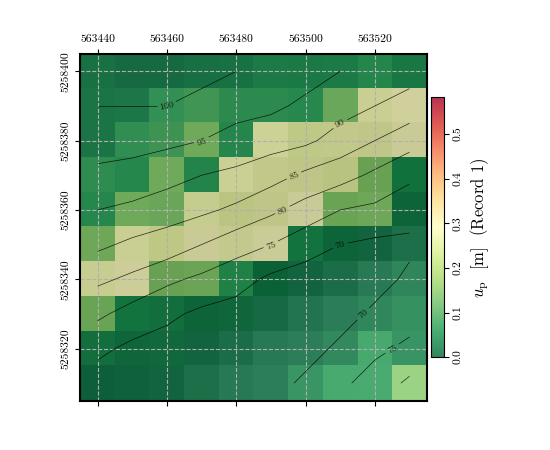

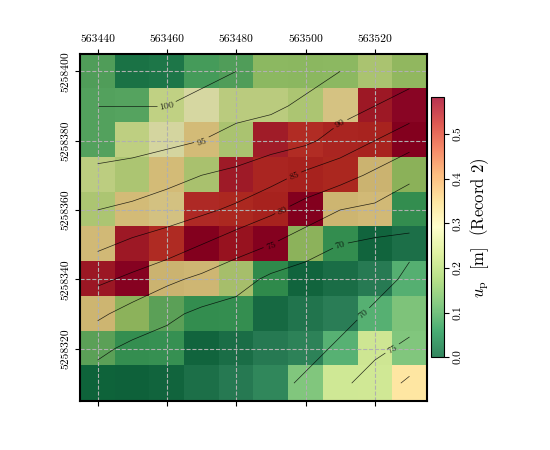

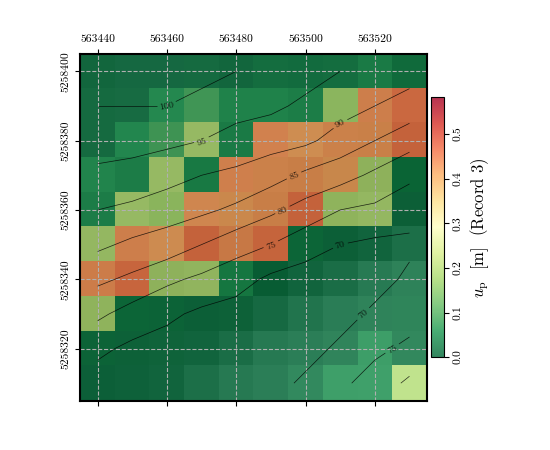

In [11]:
record_1_uₚ = spatial_newmark(record_1_time, record_1_accel, ky, g)
record_2_uₚ = spatial_newmark(record_2_time, record_2_accel, ky, g)
record_3_uₚ = spatial_newmark(record_3_time, record_3_accel, ky, g)

vmax = np.nanmax([record_1_uₚ, record_2_uₚ, record_3_uₚ])

fig = plot_spatial_field(record_1_uₚ, dem, spat_ref=header, levels=contours,
                         title="$u_\\mathrm{p}$  [m]  (Record 1)", cmap='RdYlGn_r',
                         labelrot=90, vmin= 0, vmax=vmax)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom' 
plt.show()

fig = plot_spatial_field(record_2_uₚ, dem, spat_ref=header, levels=contours,
                         title="$u_\\mathrm{p}$  [m]  (Record 2)", cmap='RdYlGn_r',
                         labelrot=90, vmin= 0, vmax=vmax)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom' 
plt.show()

fig = plot_spatial_field(record_3_uₚ, dem, spat_ref=header, levels=contours,
                         title="$u_\\mathrm{p}$  [m]  (Record 3)", cmap='RdYlGn_r',
                         labelrot=90, vmin= 0, vmax=vmax)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom' 
plt.show()

### Plotting the Newmark method at a specific location

Zone: 2.0, Height: 91.0, Slope: 35.0°, FS: 1.323, kᵧ: 0.159
uₚ (record 1): 0.258 | uₚ (record 2): 0.522 | uₚ (record 3): 0.411


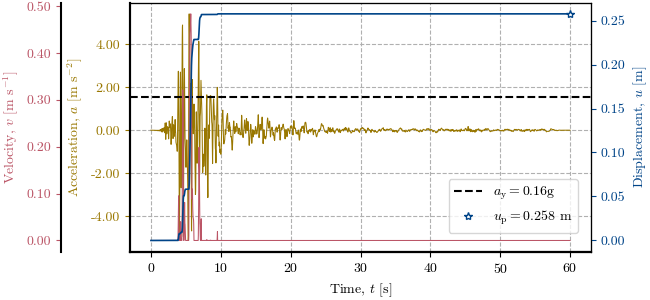

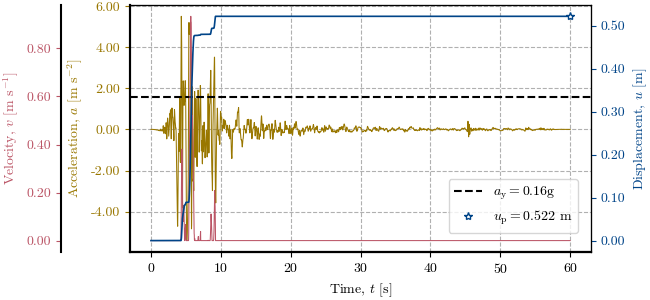

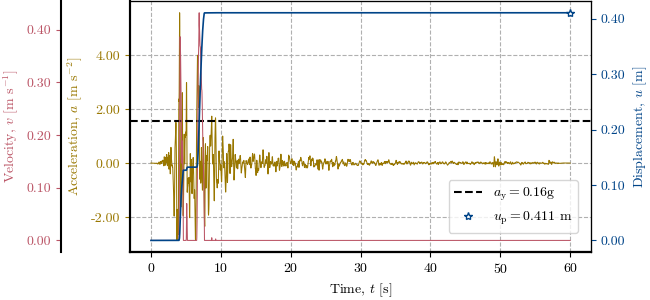

In [12]:
# Verification of the Direct Newmark Method at one cell
x, y = 563500, 5258380 # Coordinates of the cell to verify
cell = get_idx_at_coords(x=x, y=y, spat_ref=header)  # Cell to verify

print(f"Zone: {zones[cell]}, Height: {dem[cell]}, Slope: {slope[cell]}°, FS: {fs[cell]}, kᵧ: {ky[cell]}")
print(f"uₚ (record 1): {record_1_uₚ[cell]} | uₚ (record 2): {record_2_uₚ[cell]} | uₚ (record 3): {record_3_uₚ[cell]}")

# Plotting the Newmark method at the cell (single compressed plot)
newmark_str_record_1 = verify_newmark_at_cell(cell, record_1_time, record_1_accel, g, depth, depth_w, slope, phi, c, gamma)
fig = plot_newmark_integration(newmark_str_record_1, True)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

newmark_str_record_2 = verify_newmark_at_cell(cell, record_2_time, record_2_accel, g, depth, depth_w, slope, phi, c, gamma)
fig = plot_newmark_integration(newmark_str_record_2, True)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()

newmark_str_record_3 = verify_newmark_at_cell(cell, record_3_time, record_3_accel, g, depth, depth_w, slope, phi, c, gamma)
fig = plot_newmark_integration(newmark_str_record_3, True)
fig.canvas.header_visible = False 
fig.canvas.toolbar_position = 'bottom' 
plt.show()